In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.datasets import fashion_mnist




In [ ]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Нормалізуємо дані
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Розширимо останнє вимірення, щоб відповідати вимогам вхідного шару Inception-v1
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

# Закодуємо мітки класів за допомогою one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)


In [ ]:
def inception_v1(input_shape, num_classes):
    input_layer = layers.Input(shape=input_shape)

    # Stem layer
    x = layers.Conv2D(64, kernel_size=7, strides=2, padding='same', activation='relu')(input_layer)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Inception blocks
    x = inception_block(x, filters=[64, 96, 128, 16, 32, 32])
    x = inception_block(x, filters=[128, 128, 192, 32, 96, 64])
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    x = inception_block(x, filters=[192, 96, 208, 16, 48, 64])
    x = inception_block(x, filters=[160, 112, 224, 24, 64, 64])
    x = inception_block(x, filters=[128, 128, 256, 24, 64, 64])
    x = inception_block(x, filters=[112, 144, 288, 32, 64, 64])
    x = inception_block(x, filters=[256, 160, 320, 32, 128, 128])
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    x = inception_block(x, filters=[256, 160, 320, 32, 128, 128])
    x = inception_block(x, filters=[384, 192, 384, 48, 128, 128])
    x = layers.GlobalAveragePooling2D()(x)

    output_layer = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer, name='inception_v1')

    return model


In [ ]:
def inception_block(x, filters):
    f1, f3r, f3, f5r, f5, fpp = filters

    # 1x1 convolution branch
    conv1x1 = layers.Conv2D(f1, kernel_size=1, activation='relu')(x)

    # 3x3 convolution branch
    conv3x3_1 = layers.Conv2D(f3r, kernel_size=1, activation='relu')(x)
    conv3x3_2 = layers.Conv2D(f3, kernel_size=3, padding='same', activation='relu')(conv3x3_1)

    # 5x5 convolution branch
    conv5x5_1 = layers.Conv2D(f5r, kernel_size=1, activation='relu')(x)
    conv5x5_2 = layers.Conv2D(f5, kernel_size=5, padding='same', activation='relu')(conv5x5_1)

    # Max pooling branch
    max_pool = layers.MaxPooling2D(pool_size=3, strides=1, padding='same')(x)
    max_pool_conv = layers.Conv2D(fpp, kernel_size=1, activation='relu')(max_pool)

    # Concatenate branches
    concatenated = layers.concatenate([conv1x1, conv3x3_2, conv5x5_2, max_pool_conv], axis=-1)

    return concatenated


In [ ]:
input_shape = x_train.shape[1:]
num_classes = 10

model = inception_v1(input_shape, num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test))


Epoch 1/10
1875/1875 [==============================] - 69s 24ms/step - loss: 0.5874 - accuracy: 0.7766 - val_loss: 0.4164 - val_accuracy: 0.8557
Epoch 2/10
1875/1875 [==============================] - 43s 23ms/step - loss: 0.3548 - accuracy: 0.8726 - val_loss: 0.3406 - val_accuracy: 0.8821
Epoch 3/10
1875/1875 [==============================] - 43s 23ms/step - loss: 0.3085 - accuracy: 0.8893 - val_loss: 0.3056 - val_accuracy: 0.8968
Epoch 4/10
1875/1875 [==============================] - 44s 24ms/step - loss: 0.2731 - accuracy: 0.9021 - val_loss: 0.2912 - val_accuracy: 0.8927
Epoch 5/10
1875/1875 [==============================] - 42s 23ms/step - loss: 0.2539 - accuracy: 0.9085 - val_loss: 0.2860 - val_accuracy: 0.8982
Epoch 6/10
1875/1875 [==============================] - 43s 23ms/step - loss: 0.2372 - accuracy: 0.9136 - val_loss: 0.2791 - val_accuracy: 0.9029
Epoch 7/10
1875/1875 [==============================] - 43s 23ms/step - loss: 0.2285 - accuracy: 0.9170 - val_loss: 0.2816 -

In [ ]:
from keras.layers import concatenate
import tensorflow as tf
import numpy as np

img_a_in = tf.keras.layers.Input(shape = x_train.shape[1:], name = 'ImageA_Input')
img_b_in = tf.keras.layers.Input(shape = x_train.shape[1:], name = 'ImageB_Input')

img_a_feat = model(img_a_in)
img_b_feat = model(img_b_in)

features = concatenate([img_a_feat, img_b_feat], name = 'merge_features')
features = tf.keras.layers.Dense(16, activation='linear')(features)
features = tf.keras.layers.BatchNormalization()(features)
features = tf.keras.layers.Activation('relu')(features)
features = tf.keras.layers.Dense(4, activation='linear')(features)
features = tf.keras.layers.BatchNormalization()(features)
features = tf.keras.layers.Activation('relu')(features)
features = tf.keras.layers.Dense(1, activation='sigmoid')(features)

siamese_model = tf.keras.models.Model(inputs = [img_a_feat, img_b_feat], outputs = [features], name = 'Siamese_model')
siamese_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['mae'])
siamese_model.summary()

Model: "Siamese_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 merge_features (Concatenate)   (None, 20)           0           ['input_3[0][0]',                
                                                                  'input_4[0][0]']                
                                                                                                  
 dense_2 (Dense)                (None, 16)           336         ['merge_features[1][0

In [ ]:
train_groups = [x_train[np.where(y_train==i)[0]] for i in np.unique(y_train)]
test_groups = [x_test[np.where(y_test==i)[0]] for i in np.unique(y_train)]

In [ ]:
print('train groups:', [x.shape[0] for x in train_groups])
print('test groups:', [x.shape[0] for x in test_groups])

train groups: [540000, 60000]
test groups: [90000, 10000]


In [ ]:
def gen_random_batch(in_groups, batch_halfsize = 8):
    out_img_a, out_img_b, out_score = [], [], []
    all_groups = list(range(len(in_groups)))
    for match_group in [True, False]:
        group_idx = np.random.choice(all_groups, size = batch_halfsize)
        out_img_a += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in group_idx]
        if match_group:
            b_group_idx = group_idx
            out_score += [1] * batch_halfsize
        else:
            # anything but the same group
            non_group_idx = [np.random.choice([i for i in all_groups if i != c_idx]) for c_idx in group_idx]
            b_group_idx = non_group_idx
            out_score += [0]*batch_halfsize

        out_img_b += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in b_group_idx]
    return np.stack(out_img_a,0), np.stack(out_img_b,0), np.stack(out_score,0)

1/1 [==============================] - 0s 107ms/step


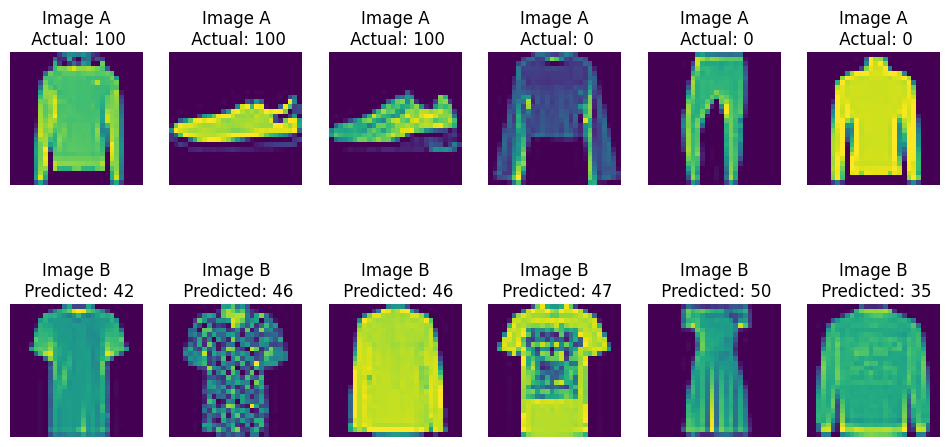

In [ ]:
import matplotlib.pyplot as plt
def show_model_output(nb_examples = 3):
    pv_a, pv_b, pv_sim = gen_random_batch(test_groups, nb_examples)
    pred_sim = siamese_model.predict([model.predict(pv_a), model.predict(pv_b)])
    fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (12, 6))
    for c_a, c_b, c_d, p_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, pred_sim, m_axs.T):
        ax1.imshow(c_a[:,:,0])
        ax1.set_title(f'Image A\n Actual: { 100 * c_d }')
        ax1.axis('off')
        ax2.imshow(c_b[:,:,0])
        ax2.set_title(f'Image B\n Predicted: {int( 100 * p_d[0] )}')
        ax2.axis('off')
    return fig
# a completely untrained model
_ = show_model_output()

In [ ]:
def siam_gen(in_groups, batch_size = 32):
    while True:
        pv_a, pv_b, pv_sim = gen_random_batch(in_groups, batch_size//2)
        yield [model.predict(pv_a), model.predict(pv_b)], pv_sim

valid_a, valid_b, valid_sim = gen_random_batch(test_groups, 1024)
loss_history = siamese_model.fit(siam_gen(train_groups),
    steps_per_epoch = 500,
    validation_data=([model.predict(valid_a), model.predict(valid_b)],
    valid_sim),
    epochs = 4,
    verbose = True)

1/1 [==============================] - 0s 20ms/step
Epoch 1/4
500/500 [==============================] - 808s 2s/step - loss: 0.7083 - mae: 0.4995 - val_loss: 0.6958 - val_mae: 0.4999
Epoch 2/4
500/500 [==============================] - 804s 2s/step - loss: 0.6950 - mae: 0.4998 - val_loss: 0.6965 - val_mae: 0.5008
Epoch 3/4
500/500 [==============================] - 816s 2s/step - loss: 0.6947 - mae: 0.5000 - val_loss: 0.6951 - val_mae: 0.5005
Epoch 4/4
500/500 [==============================] - 826s 2s/step - loss: 0.6939 - mae: 0.4999 - val_loss: 0.6945 - val_mae: 0.5003


1/1 [==============================] - 0s 18ms/step


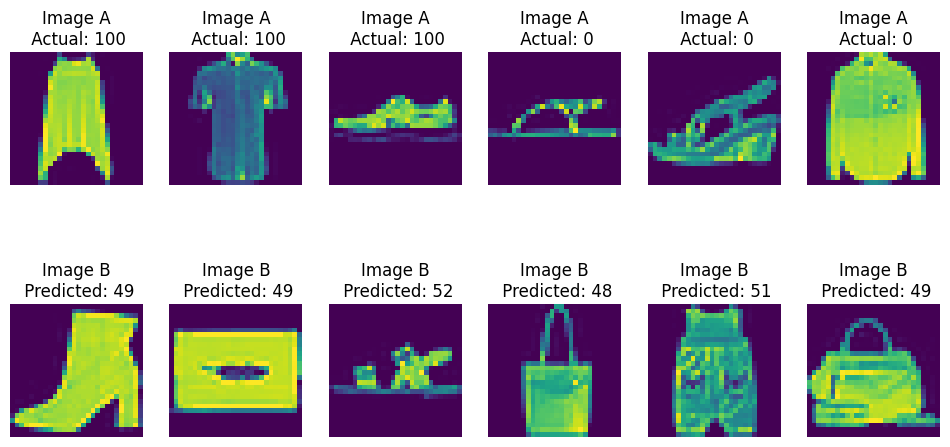

In [ ]:
_ = show_model_output()

In [ ]:
%%time
from sklearn.manifold import TSNE
x_test_features = model.predict(x_test, verbose = True, batch_size=128)

tsne_obj = TSNE(n_components=2,
    init='pca',
    random_state=101,
    method='barnes_hut',
    n_iter=500,
    verbose=1)
tsne_features = tsne_obj.fit_transform(x_test_features)

79/79 [==============================] - 2s 9ms/step
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.015s...
[t-SNE] Computed neighbors for 10000 samples in 0.405s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.514221
[t-SNE] KL divergence afte

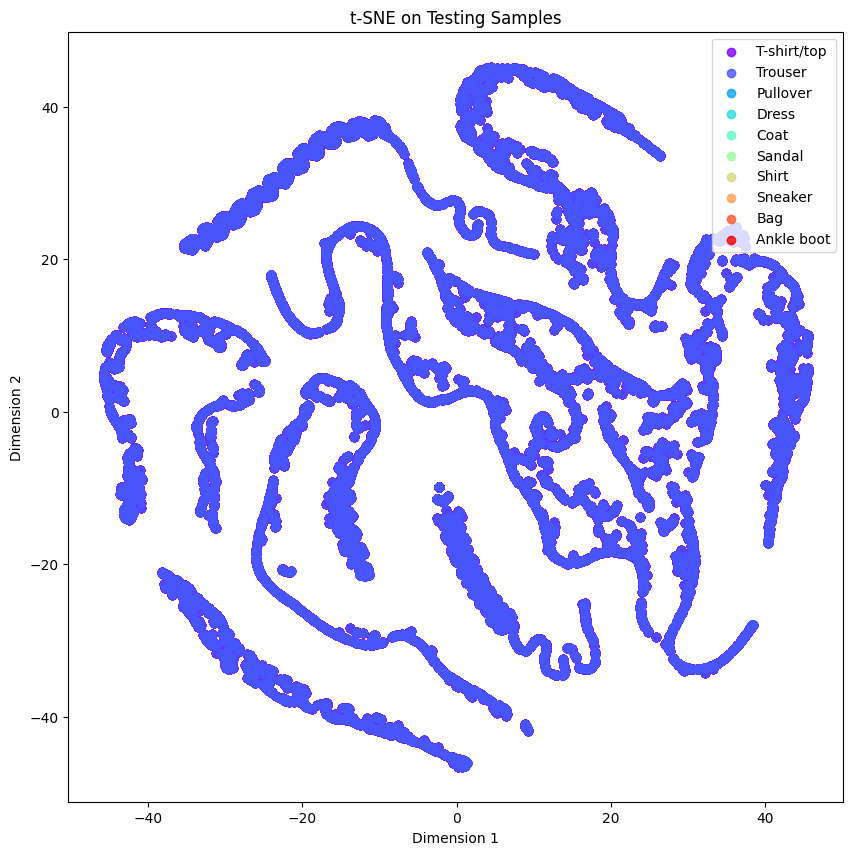

In [ ]:
obj_categories = [  
                    'T-shirt/top','Trouser','Pullover','Dress',
                    'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'
                 ]
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))

for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
    plt.scatter(tsne_features[np.where(y_test == c_group), 0],
        tsne_features[np.where(y_test == c_group), 1],
        marker='o',
        color=c_color,
        linewidth=1,
        alpha=0.8,
        label=c_label)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE on Testing Samples')
plt.legend(loc='best')
plt.savefig('clothes-dist.png')
plt.show(block=False)